## 3) 주어진 호텔 리뷰 데이터를 가지고 할 수 있는 분석이 있으면 더 진행해보시오.

In [ ]:
from google.colab import drive
import re
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud

### 가정: 별점 비율이 동일한 데이터로 학습한 모델의 성능이 더 좋을 것이다
- 별점 비율이 동일한 data를 생성한다
- 해당 데이터를 training 데이터로 사용하여 모델을 만들고 홀수 번째 행의 호텔 리뷰를 가지고 rating 값을 예측하는 모델을 만든다
- 어떤 단어가 좋은 호텔 리뷰에 많이 쓰이고 어떤 단어가 나쁜 호텔 리뷰에 많이 쓰이는지 분석한다

1. 20K 호텔 리뷰 데이터 호출

In [ ]:
drive.mount('/content/drive')

df = pd.read_csv('Hotel_reviews_20k.csv', encoding='latin1')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,rating_review,review_full,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,5,Been going to honk for quite a while . This ma...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,We have been a frequent visitor at this chain ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,"Excellent staff, very cooperative and gentle ....",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,I have always visit this place.they always off...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Lot of appraise about Chef Deepak Chef Wangmo ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


2. 별점 별 비율 비교
- 평점별 데이터 수가 다르다
- 따라서 가장 데이터가 적은 1점 데이터의 수를 기준으로 training 데이터를 만든다

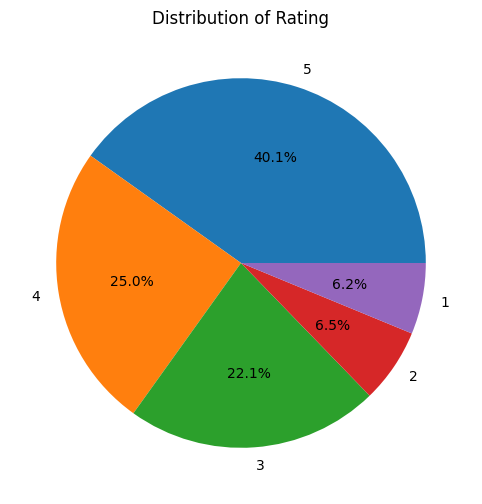

In [ ]:
rating_counts = df['rating_review'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Rating')
plt.show()

In [ ]:
df_ALL = pd.read_csv('Hotel_reviews_20k.csv', encoding='latin1')
df_ALL=df_ALL.sample(frac=1).reset_index(drop=True)

df_1 = df_ALL.loc[df_ALL['rating_review']== 1 ]
df_2 = df_ALL.loc[df_ALL['rating_review']== 2 ]
df_3 = df_ALL.loc[df_ALL['rating_review']== 3 ]
df_4 = df_ALL.loc[df_ALL['rating_review']== 4 ]
df_5 = df_ALL.loc[df_ALL['rating_review']== 5 ]

rating_lengths = [len(df.loc[df['rating_review'] == rating].review_full) for rating in range(1, 6)]
min_length = min(rating_lengths)


df_1 = df_1[:min_length]
df_2 = df_2[:min_length]
df_3 = df_3[:min_length]
df_4 = df_4[:min_length]
df_5 = df_5[:min_length]

df_same =pd.concat([df_1,df_2,df_3,df_4,df_5], ignore_index=True); df_same

,rating_review,review_full,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,1,Another restaurant in Delhi that serves expens...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,be-aware!! the waiters lie about the cost of d...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,This is the folk they give me for dinner...i r...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,If you are looking to hangout in a tucked away...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,This restaurant needs to be renovated to moder...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6220,5,The restaurant was okayish but the biryani was...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6221,5,Bukhara under the umbrella of Maurya Sherton i...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6222,5,Last Saturday we went for lunch at the Orienta...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6223,5,The dinning experience was awesome have dinned...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


3. 리뷰 데이터와 레이블 추출
- 동일한 별점 비율을 가진 리뷰를 training 데이터로 사용
- 홀수 번째 행의 리뷰를 testing 데이터로 사용

In [ ]:
X = df['review_full']
Y = df['rating_review']

train_X = df_same['review_full'].values
train_P = df_same['rating_review'].values

test_X = X[::2].values
test_P = Y[::2].values

train_P = train_P.reshape((len(train_P), 1))
test_P = test_P.reshape((len(test_P), 1))

4. 토큰화, 시퀀스 패딩
- 매개변수는 사용할 단어의 최대 개수는 1000개로 한다
- 300단어가 되지 않는 데이터들은 `<OOV>`로 채운다

In [ ]:
vocab_size = 1000
embedding_dim = 20
max_length = 300
trunc_type='post'
oov_tok = '<OOV>'

# 토큰화 진행
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_X)
word_index = tokenizer.word_index

# 텍스트 시퀀스를 정수 시퀀스로 변환
training_sequences = tokenizer.texts_to_sequences(train_X)
testing_sequences = tokenizer.texts_to_sequences(test_X)

# 시퀀스 패딩
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding='post', truncating=trunc_type)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding='post', truncating=trunc_type)

5. 모델 구축
- 시퀀스의 길이에 관계없이 고정된 크기의 출력을 얻기 위해 `GlobalAveragePooling1D` 을 사용한다
- 활성 함수로 `relu`와 `sigmoid`를 사용한다
- 과적합 방지를 위해 dropout 레이어를 추가한다

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation='sigmoid')
])

loss_fn = keras.losses.SparseCategoricalCrossentropy()
model.compile(loss=loss_fn,optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 20)           20000     
                                                                 
 global_average_pooling1d_2   (None, 20)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 16)                336       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 6)                 102       
                                                      

6. 모델 학습
- epochs는 30으로, batch size는 64로 한다

In [ ]:
history = model.fit(training_padded, train_P, epochs=30, batch_size=64, validation_split=0.2)

Epoch 1/30
78/78 [==============================] - 10s 109ms/step - loss: 1.7264 - accuracy: 0.2498 - val_loss: 2.1901 - val_accuracy: 0.0000e+00
Epoch 2/30
78/78 [==============================] - 4s 55ms/step - loss: 1.5448 - accuracy: 0.2624 - val_loss: 3.3213 - val_accuracy: 0.0000e+00
Epoch 3/30
78/78 [==============================] - 2s 29ms/step - loss: 1.4443 - accuracy: 0.2655 - val_loss: 4.3511 - val_accuracy: 0.0000e+00
Epoch 4/30
78/78 [==============================] - 2s 29ms/step - loss: 1.4099 - accuracy: 0.2823 - val_loss: 4.8402 - val_accuracy: 0.0000e+00
Epoch 5/30
78/78 [==============================] - 2s 23ms/step - loss: 1.3937 - accuracy: 0.2970 - val_loss: 5.1822 - val_accuracy: 0.0000e+00
Epoch 6/30
78/78 [==============================] - 1s 18ms/step - loss: 1.3788 - accuracy: 0.2982 - val_loss: 5.4026 - val_accuracy: 0.0000e+00
Epoch 7/30
78/78 [==============================] - 1s 12ms/step - loss: 1.3654 - accuracy: 0.3143 - val_loss: 5.5462 - val_accu

7. 테스트 데이터 정확도 확인
- 정확도는 35% 이다


In [ ]:
model.evaluate(testing_padded, test_P, verbose=0)  # 0.35100001096725464

[3.750617504119873, 0.35100001096725464]

8. 그래프로 과적합 확인하기
- loss는 감소하지만 accuracy는 0.35에서 머문다
- 모델에 입력되는 특징들이 뚜렷하지 않아 중요한 정보를 잘 전달하지 못한 것이라 판단한다
- 따라서 가설 '별점 비율이 동일한 데이터로 학습한 모델의 성능이 더 좋을 것이다'는 틀렸다

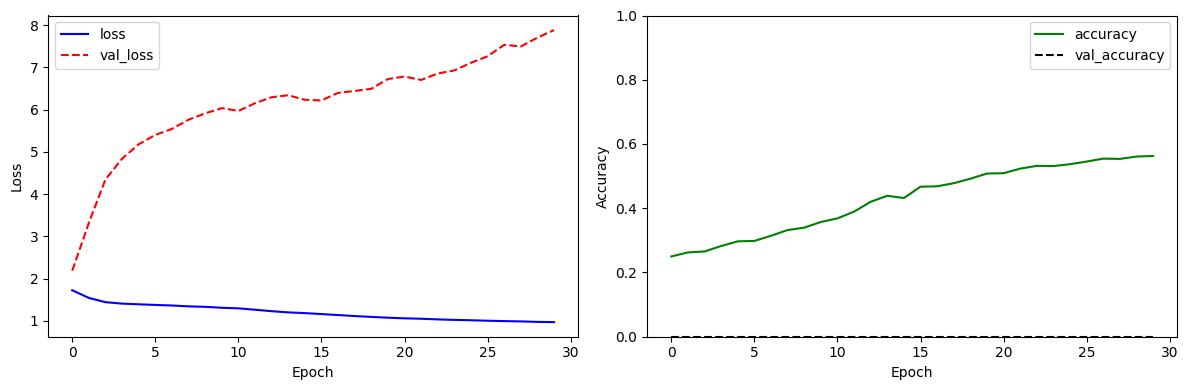

In [ ]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Loss 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], 'b-', label='loss')
    plt.plot(history.history['val_loss'], 'r--', label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], 'g-', label='accuracy')
    plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0.0, 1.0)
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)